In [1]:
import torch
import datetime
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models.resnet import ResNet50_Weights
import matplotlib.pyplot as plt

In [2]:
raw_train_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', download=True)
raw_test_dataset = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test', download=True)

print(len(raw_train_dataset))
print(len(raw_test_dataset))

100%|██████████| 791918971/791918971 [00:53<00:00, 14919344.48it/s]


Extracting data/oxford-pets/oxford-iiit-pet/images.tar.gz to data/oxford-pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 9261881.04it/s] 


Extracting data/oxford-pets/oxford-iiit-pet/annotations.tar.gz to data/oxford-pets/oxford-iiit-pet
3680
3669


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
# print(clip_model)

In [5]:
from torch.utils.data import Dataset

class preprocessDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, target = self.dataset[index]
        augmented_image = self.transform(image)
        return augmented_image, target

In [6]:
R50_transform = T.Compose([
                            T.Resize((224,224)),
                            T.ToTensor(),
                            T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                          ])

In [7]:
train_dataset = preprocessDataset(raw_train_dataset, R50_transform)
test_dataset = preprocessDataset(raw_test_dataset, R50_transform)

In [8]:
raw_sample = []
train_sample = []

rw = iter(raw_train_dataset)
tr = iter(train_dataset)

for i in range(16):
    raw_sample.append(next(rw)[0])
    train_sample.append(next(tr)[0])

grid1 = torchvision.utils.make_grid([T.Resize((224,224),antialias=True)(T.ToTensor()(i)) for i in raw_sample], nrow=8)
grid2 = torchvision.utils.make_grid([i for i in train_sample], nrow=8)

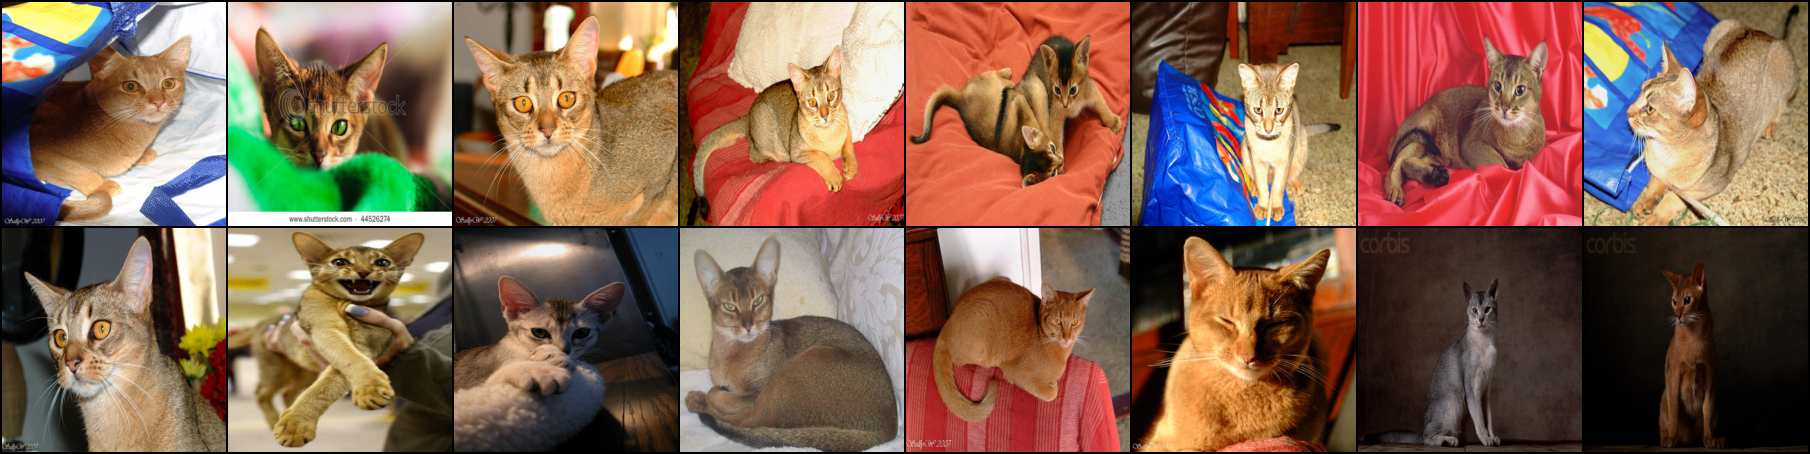

In [9]:
# raw sample preview
T.ToPILImage()(grid1)

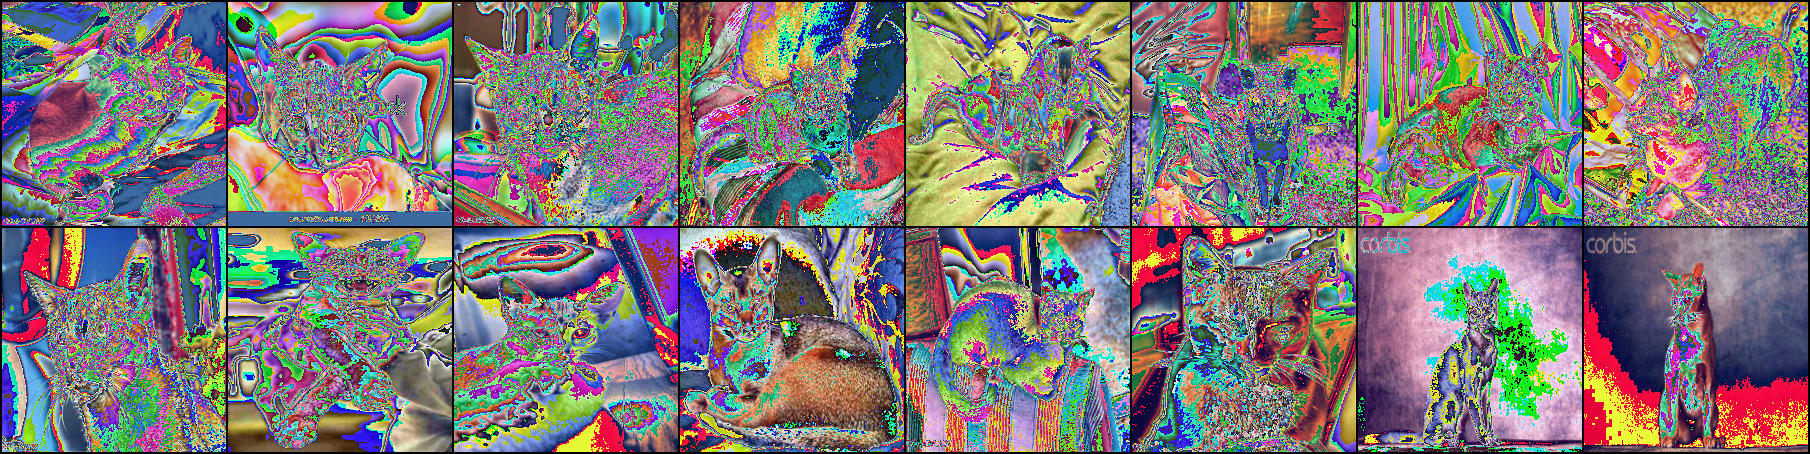

In [10]:
# train sample preview after clip preprocessing
T.ToPILImage()(grid2)

In [11]:
from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=0)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2944
736
3669


In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:",len(val_loader))
print("Test batches:",len(test_loader))

Train batches: 46
Val batches: 12
Test batches: 58


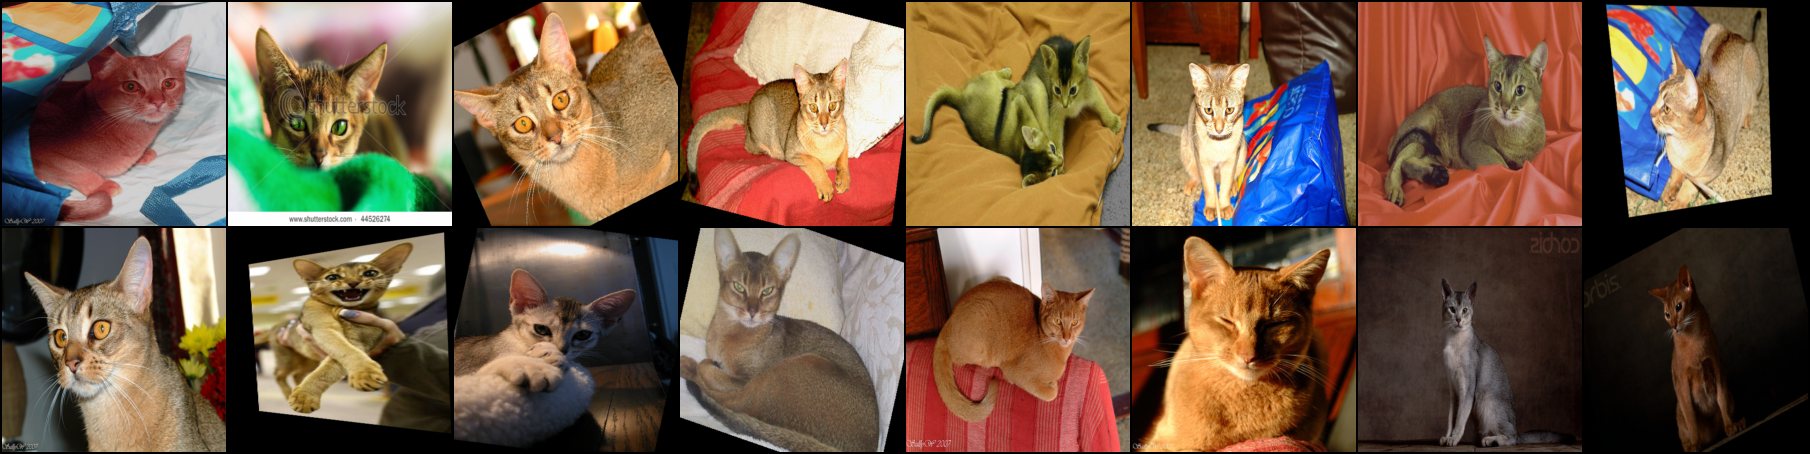

In [18]:
train_transform = T.RandomChoice([
                                    T.RandomRotation(30),
                                    T.ColorJitter(brightness=[0.8,1.4], hue=0.1,saturation = 0.1),
                                    T.RandomHorizontalFlip(0.4),
                                    T.RandomPerspective(distortion_scale=0.4)
                                ], [0.3, 0.3, 0.3, 0.1])

tt = []
for i in [T.ToTensor()(i) for i in raw_sample]:
    tt.append(train_transform(i))

grid = torchvision.utils.make_grid([T.Resize((224,224),antialias=True)(i) for i in tt], nrow=8)
T.ToPILImage()(grid)

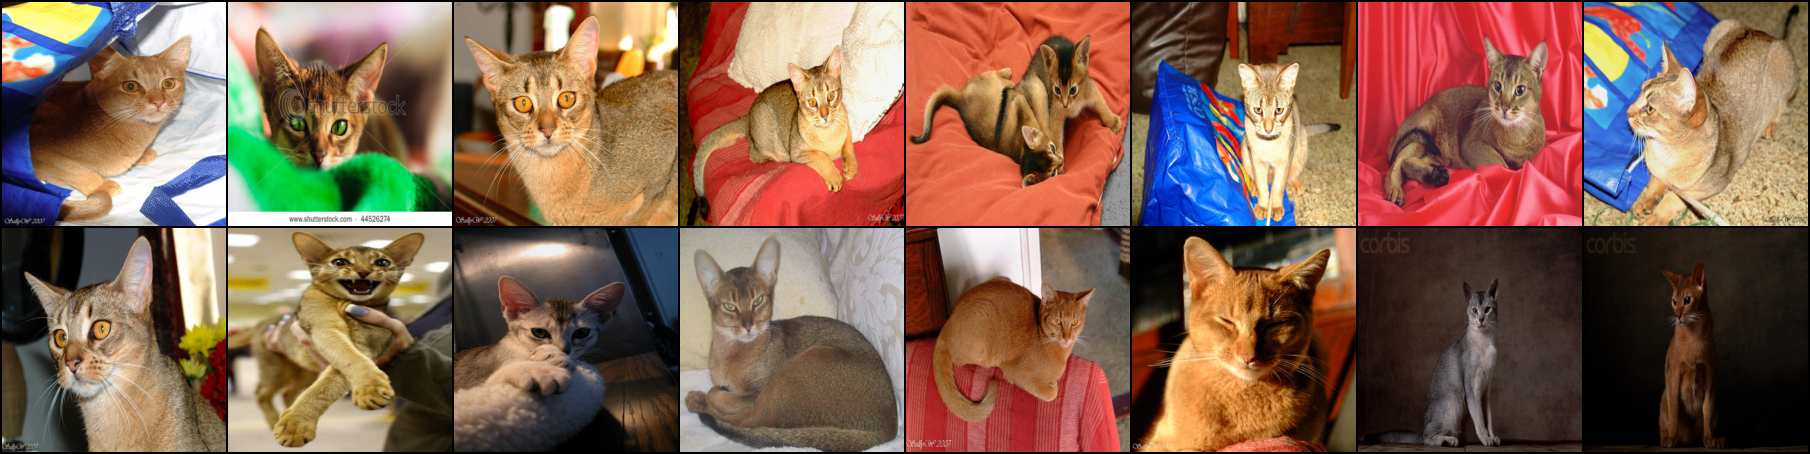

In [15]:
# Original Images
T.ToPILImage()(grid1)